# Clustering Anomaly Detection

## Clustering - DBSCAN

### 1. Use DBSCAN to detect anomalies in other products from the customers dataset.



### 2. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

### Imports

In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")

In [4]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 30.9 KB


In [6]:
df.shape

(440, 8)

In [8]:
df.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

In [9]:
# df.drop(["Channel", "Region"], axis = 1, inplace = True)
df = df[['Frozen', 'Detergents_Paper', 'Delicassen']]

In [10]:
df.head()

,Frozen,Detergents_Paper,Delicassen
customer_id,,,
0,214,2674,1338
1,1762,3293,1776
2,2405,3516,7844
3,6404,507,1788
4,3915,1777,5185


In [11]:
np_array = df.values.astype("float32", copy = False)
np_array[0:10]

array([[ 214., 2674., 1338.],
       [1762., 3293., 1776.],
       [2405., 3516., 7844.],
       [6404.,  507., 1788.],
       [3915., 1777., 5185.],
       [ 666., 1795., 1451.],
       [ 480., 3140.,  545.],
       [1669., 3321., 2566.],
       [ 425., 1716.,  750.],
       [1159., 7425., 2098.]], dtype=float32)

In [12]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.0031063 , 0.0654272 , 0.02784731],
       [0.02854842, 0.08058985, 0.03698373],
       [0.03911643, 0.08605233, 0.16355862],
       [0.1048419 , 0.01234568, 0.03723405],
       [0.063934  , 0.04345483, 0.10809346],
       [0.01053514, 0.04389575, 0.03020442],
       [0.00747814, 0.07684205, 0.0113058 ],
       [0.02701992, 0.08127572, 0.05346267],
       [0.00657419, 0.04196061, 0.01558198],
       [0.01863783, 0.18180482, 0.04370046]], dtype=float32)

In [13]:
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

In [14]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [15]:
#extract cluster labels
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
df['labels'] = labels
df.labels.value_counts()

 0    423
-1     17
Name: labels, dtype: int64

In [17]:
df[df.labels==-1].head()

,Frozen,Detergents_Paper,Delicassen,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen,labels
23,5154,4337,16523,0.084298,0.106163,0.344597,-1
47,7782,24171,6465,0.127490,0.592005,0.134793,-1
56,2616,17740,1340,0.042584,0.434475,0.027889,-1
61,3254,26701,2017,0.053070,0.653978,0.042011,-1
65,36,24231,1423,0.000181,0.593474,0.029620,-1


In [18]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
             Frozen  Detergents_Paper    Delicassen  Scaled_Frozen  \
count    440.000000        440.000000    440.000000     440.000000   
mean    3071.931818       2881.493182   1524.870455       0.050078   
std     4854.673333       4767.854448   2820.105937       0.079789   
min       25.000000          3.000000      3.000000       0.000000   
25%      742.250000        256.750000    408.250000       0.011788   
50%     1526.000000        816.500000    965.500000       0.024670   
75%     3554.250000       3922.000000   1820.250000       0.058005   
max    60869.000000      40827.000000  47943.000000       1.000000   

       Scaled_Detergents_Paper  Scaled_Delicassen      labels  
count               440.000000         440.000000  440.000000  
mean                  0.070510           0.031745   -0.038636  
std                   0.116790           0.058826    0.192946  
min                   0.000000           0.000000   -1.000000  
25%                   0.006216        

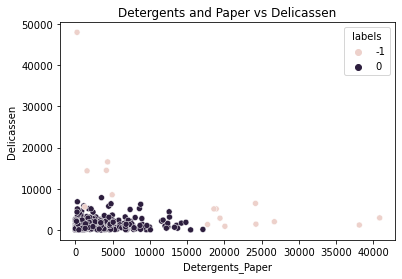

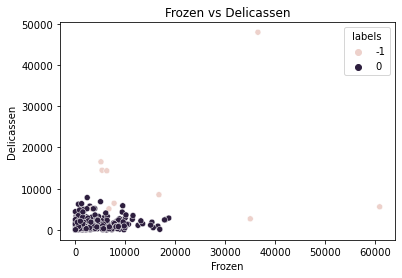

In [22]:
sns.scatterplot(df.Detergents_Paper, df.Delicassen, hue=df.labels)
plt.title('Detergents and Paper vs Delicassen')
plt.show()

sns.scatterplot(df.Frozen, df.Delicassen, hue=df.labels)
plt.title('Frozen vs Delicassen')
plt.show()

Text(0.5, 0, 'Grocery')

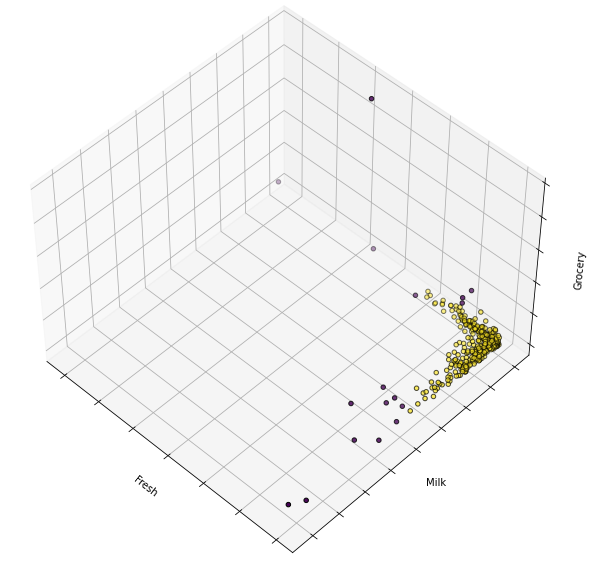

In [23]:
# 3d viz
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Frozen, df.Detergents_Paper, df.Delicassen,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Milk')
ax.set_zlabel('Grocery')